In [1]:
# Parser for Passatuto data
import sys
sys.path.append('C:\\Users\\Gosia\\Desktop\\FDR-Metabolomics\\src\\passatuto_parser.py')
import passatuto_parser as pp

In [2]:
# Taking all the files from MassBankOrbi (queries) and parsing them to json objects
pre_spectrums_query = pp.PassatutoParser(r'C:\\Users\\Gosia\\Desktop\\MassbankOrbi').parse_folder()

processed 100 files
processed 200 files
processed 300 files
processed 400 files
Finished parsing of 457 spectra 


In [3]:
# Taking all files from Gnps (library) and parsing them to json objects
pre_spectrums_lib = pp.PassatutoParser('C:\\Users\\Gosia\\Desktop\\Gnps').parse_folder()

processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
Finished parsing of 4077 spectra 


In [ ]:
# Using MatchMS to create spectra for both
from matchms.importing.load_from_json import as_spectrum
spectrums_query = []
for i, s in enumerate( pre_spectrums_query ):
    spectrums_query.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
spectrums_lib = []
for i, s in enumerate( pre_spectrums_lib ):
    spectrums_lib.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)

In [ ]:
# Calculating cosine similarity for target-query match
from cosine_calc import get_hits
hits = get_hits(spectrums_query, spectrums_lib, 2, cosine_tol=0.005)

In [ ]:
# Loading the decoy database
pre_spectrums_decoys_cond = pp.DecoyParserPassatuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyConditionalPeaks').parse_folder()
pre_spectrums_decoys_rand = pp.DecoyParserPassatuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyRandomPeaks').parse_folder()

In [ ]:
# Using MatchMS to create decoy spectra
decoys_cond = []
for i, s in enumerate( pre_spectrums_decoys_cond ):
    decoys_cond.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

decoys_rand = []
for i, s in enumerate( pre_spectrums_decoys_rand ):
    decoys_rand.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)


In [ ]:
if False:
    from rdkit.Chem import MolFromSmiles, MolToSmiles, MolFromInchi
    from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
    def add_pmz(specs):
        for s in specs:
            s.set('precursor_mz', s.get('parent_mass', 0))

    add_pmz(spectrums_query)

In [ ]:
# Calculating cosine similarity for query-decoy match
from cosine_calc import get_hits
hits_decoys_cond = get_hits(spectrums_query, decoys_cond, 3, "precursor_mz", cosine_tol=0.1, decoys=True)
hits_decoys_rand = get_hits(spectrums_query, decoys_rand, 3, "precursor_mz", cosine_tol=0.1, decoys=True)


In [ ]:
print(len(hits))
print(len(hits_decoys_cond))
print(len(hits_decoys_rand))

In [13]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [14]:
# Calculating estimated q-value scores
q_list_estimated = calculate_q_value(hits+hits_decoys,True)
q_list_estimated_rand = calculate_q_value(hits+hits_decoys_rand,True)
print(q_list_estimated)

[(0, False, 0.9186412661034927), (0.0, True, 0.9081013114506945), (0.0, False, 0.877336375886237), (0.14285714285714285, 'decoy', 0.870600609959416), (0.14285714285714285, True, 0.8696886418767396), (0.14285714285714285, True, 0.8418044455659321), (0.14285714285714285, False, 0.8168194642551653), (0.18181818181818182, 'decoy', 0.8108462944321183), (0.18181818181818182, False, 0.8097711197208923), (0.18181818181818182, True, 0.8075517145934534), (0.18181818181818182, True, 0.8019139221301643), (0.18518518518518517, 'decoy', 0.8014953862201359), (0.18518518518518517, False, 0.7977382874441272), (0.18518518518518517, True, 0.7928221262021007), (0.18518518518518517, 'decoy', 0.7919002748136683), (0.18518518518518517, True, 0.7837751633281397), (0.18518518518518517, False, 0.7790532457710451), (0.18518518518518517, True, 0.7754094149750679), (0.18518518518518517, False, 0.7753632587809058), (0.18518518518518517, True, 0.7716388222685175), (0.18518518518518517, 'decoy', 0.7674201428099866), 

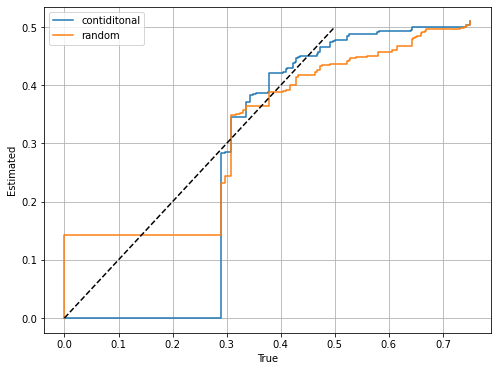

In [15]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
scores, trues, estimateds = zip(*combine_true_est(q_list_true, q_list_estimated))
scores_rand, trues_rand, estimateds_rand = zip(*combine_true_est(q_list_true, q_list_estimated_rand))

import plot_q_vals
plot_q_vals.plot_q_vals( {'contiditonal':(trues,estimateds), 'random':(trues_rand,estimateds_rand)} )

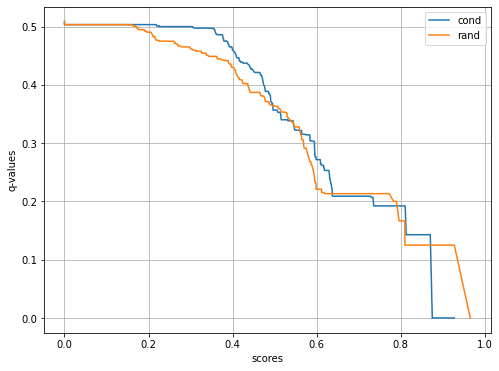

In [15]:
import pylab as plt

plt.figure(figsize=(8,6))
plt.plot(scores, estimateds, label='cond')
plt.plot(scores_rand, estimateds_rand, label='rand')
#plt.plot(scores_rand, trues_rand, label='trues')
plt.xlabel('scores')
plt.ylabel('q-values')
plt.legend()
plt.grid()

In [16]:
# this cell is just loading their cosine similarity and saving them by the query compound name
cosine_scores = open(r'C:\Users\Gosia\Desktop\q_values\MassbankOrbi-Gnps.txt', 'r').readlines() 
query_scores = {}
for line in cosine_scores[1:]:
    q,t,ti,s = line.split("\t") # q for query, t for target, ti for target inchi, s for score
    query_scores[q] = (float(s),t,ti)
    

In [17]:
# useful for visualisation of cosine differences
same = 0
different = 0
for hit in hits:
    if hit.target.get('compound_name') == query_scores[hit.query.get('compound_name')][1]:
        same += 1
    else:
        different += 1
    print('\t'.join((hit.query.get('compound_name'),hit.target.get('compound_name'), query_scores[hit.query.get('compound_name')][1], str(hit.score), str(query_scores[hit.query.get('compound_name')][0]))))
print(same, different)  

DErySphingosine	C18_Sphingosine	C18_Sphingosine	0.9277338131401497	0.8232295929697477
Prednisolone	Prednisolone	Prednisolone	0.9178586467476109	0.927530390141308
Hydrochlorothiazide	58-93-5	58-93-5	0.8968967400445442	0.8491576140089205
Clotrimazole	CLOTRIMAZOLE	CLOTRIMAZOLE	0.8753596956697863	0.7911624344085376
Methylprednisolone	Methylprednisolone	Methylprednisolone	0.844044967572292	0.9175689084373738
Quercetin	Ellagic acid	MLS002153851-01!2-(3,4-dihydroxyphenyl)-3,5,7-trihydroxy-4H-chromen-4-one dihydrate117-39-5	0.8132432846286978	0.6399952123966156


KeyError: 'Arginine'

# Below is my attempt at Grid-Searching the cosine-tolerance parameter
# For each of the chosen tolerance-candidates, I see:
# 1) how many queries result in the same target by choosing the highest score
# 2) what is the average cosine-similarity difference between our scores and their, given the same query & target

In [ ]:
from matchms.similarity import CosineGreedy
from rdkit.Chem.inchi import InchiToInchiKey, MolToInchiKey
import bisect
from collections import namedtuple

Hit = namedtuple('Hit', ['query', 'target', 'score', 'hit'])


def inchis_equal(s1, s2):
    return s1.metadata['inchi'].split("/")[:4] == s2.metadata['inchi'].split("/")[:4]
    # return InchiToInchiKey(s1.metadata['inchi']).split('-')[0] == InchiToInchiKey(s2.metadata['inchi']).split('-')[0]


def get_hits_2(query_spec, library_spec, precursor_tol=1, metaKey='parent_mass', cosine_tol=0.1):
    cosine_greedy = CosineGreedy(tolerance=cosine_tol)
    library_spec.sort(key=lambda x: x.metadata[metaKey])
    hits = []
    misses = []
    library_prec_list = [x.metadata[metaKey] for x in library_spec]
    for q in query_spec:
        if metaKey not in q.metadata:
            continue
        min_mz = q.metadata[metaKey] - precursor_tol
        max_mz = q.metadata[metaKey] + precursor_tol
        pos = bisect.bisect_right(library_prec_list, min_mz)
        pos2 = pos
        while pos2 < len(library_prec_list) and library_prec_list[pos2] < max_mz:
            pos2 += 1
        if pos == pos2:
            # nothing in precursor range
            misses.append(q)
        else:
            scores = []
            for l in library_spec[pos:pos2]:
                s, _ = cosine_greedy.pair(q, l)
                scores.append((s, l))
            # if all( s[0] == 0.0 for s in scores ):
            #    print(q.get('compound_name'))
            for score in scores:
                hits.append(Hit(q, score[1], score[0], inchis_equal(q, score[1])))
    return hits, misses


In [ ]:
tolerances = [ 0.0, 0.001, 0.005, 0.01, 0.02, 0.08, 0.1, 0.12, 0.2, 0.4, 0.75, 0.9, 1.0, 1.1, 1.3, 1.5, 2.0 ]
for tolerance in tolerances:
    hit_count = 0
    hits, _ = get_hits(spectrums_query, spectrums_lib, cosine_tol=tolerance)    
    for hit in hits:
        if hit.target.get('compound_name') == query_scores.get(hit.query.get('compound_name'), ['',''])[1]:
            hit_count += 1

    score_diff = 0.0
    hits_2, _ = get_hits_2(spectrums_query, spectrums_lib, cosine_tol=tolerance)    
    for hit in hits_2:
        if hit.target.get('compound_name') == query_scores.get(hit.query.get('compound_name'), ['',''])[1]:
            score_diff += abs(hit.score - query_scores.get(hit.query.get('compound_name'))[0])
    
    print( tolerance, hit_count, score_diff/192 )

In [ ]:
print(spectrums_query[0].get_peaks_array())

In [ ]:
# spectrum objects have a `peaks` attribute. First item is a list of mz and second a list of intensities

In [ ]:
import numpy as np

In [ ]:
class Peak(object):
    def __init__(self, mz, intensity):
        self.mz = mz
        self.intensity = intensity

def spec2peaks(spec):
    peaks = []
    for i,mz in enumerate(spec.peaks[0]):
        intensity = spec.peaks[1][i]
        peaks.append(Peak(mz, intensity))
    return peaks

def find_matches(peaks1, peaks2, ms2_tol):
    # find all the peaks in peaks that are within tol
    matches = []
    for p1 in peaks1:
        for p2 in peaks2:
            if abs(p1.mz - p2.mz) < ms2_tol:
                matches.append((p1,p2,p1.intensity*p2.intensity))
    matches.sort(key = lambda x: x[2], reverse = True)
    return matches
    
def normalise_peaks(peaks):
    max_intensity = max([p.intensity for p in peaks])
    new_peaks = []
    for peak in peaks:
        new_peaks.append(Peak(peak.mz, peak.intensity / max_intensity))
    return new_peaks

def greedy_cosine(spec1, spec2, ms2_tol=0.2, normalise = False):
    peaks1 = spec2peaks(spec1)
    peaks2 = spec2peaks(spec2)

    if normalise:
        peaks1 = normalise_peaks(peaks1)
        peaks2 = normalise_peaks(peaks2)


    
    matches = find_matches(peaks1, peaks2, ms2_tol)
    
    
    length1 = sum([p.intensity**2 for p in peaks1])
    length2 = sum([p.intensity**2 for p in peaks2])
    
    used = set()
    cos = 0
    n_matches = 0
    for p1, p2, i_prod in matches:
        if not p1 in used and not p2 in used:
            cos += i_prod
            used.add(p1)
            used.add(p2)
            n_matches += 1
    result = (n_matches, cos/(np.sqrt(length1)*np.sqrt(length2)))
    return result

def pass_cosine(spec1, spec2, ms2_tol=0.2, normalise = False):
    peaks1 = spec2peaks(spec1)
    peaks2 = spec2peaks(spec2)
    
    if normalise:
        peaks1 = normalise_peaks(peaks1)
        peaks2 = normalise_peaks(peaks2)

    length1 = sum([p.intensity**2 for p in peaks1])
    length2 = sum([p.intensity**2 for p in peaks2])


    n_matches = 0
    cos = 0
    for p1 in peaks1:
        best_match = None
        for p2 in peaks2:
            if abs(p1.mz - p2.mz) < ms2_tol:
                if best_match is None:
                    best_match = p2
                elif p2.intensity > best_match.intensity:
                    print('more than one peak')
                    best_match = p2
        if best_match is not None:
            n_matches += 1
            cos += p1.intensity * best_match.intensity
    
    result = (n_matches, cos/(np.sqrt(length1)*np.sqrt(length2)))
    return result

    
print(greedy_cosine(spectrums_query[1], spectrums_query[1], normalise=True))
print(pass_cosine(spectrums_query[1], spectrums_query[1]))